In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set(style="whitegrid")
ev_demo = pd.read_csv("data/ev-zipcode-demographics.csv")
vehicles = pd.read_csv("data/vehicle-fuel-type-counts-2024.csv")

# standardize ZIP code
ev_demo["ZIP"] = ev_demo["ZIP"].astype(str).str.zfill(5)
vehicles["ZIP Code"] = vehicles["ZIP Code"].astype(str).str.zfill(5)

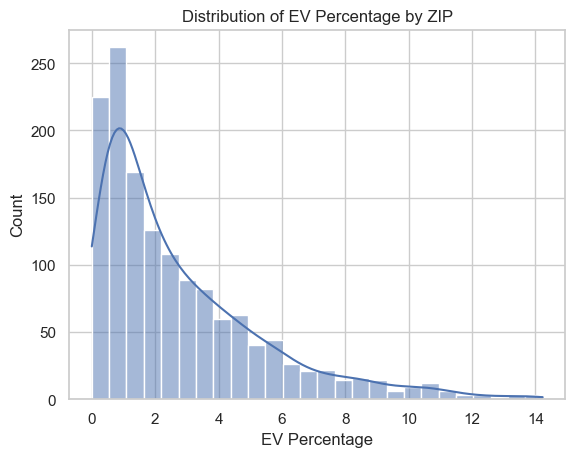

In [9]:
sns.histplot(ev_demo["EV_perc"], kde=True)
plt.title("Distribution of EV Percentage by ZIP")
plt.xlabel("EV Percentage")
plt.show()

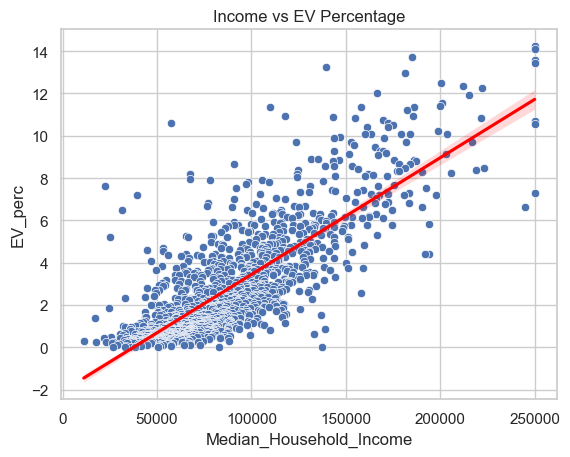

In [10]:
sns.scatterplot(data=ev_demo, x="Median_Household_Income", y="EV_perc")
sns.regplot(data=ev_demo, x="Median_Household_Income", y="EV_perc", scatter=False, color='red')
plt.title("Income vs EV Percentage")
plt.show()

In [12]:
race_cols = [f'{race}_perc' for race in ["Latino", "White", "Asian", "Black"]]
corr = ev_demo[["EV_perc"] + race_cols].corr()
corr

,EV_perc,Latino_perc,White_perc,Asian_perc,Black_perc
EV_perc,1.000000,-0.497584,0.219374,0.479023,-0.081144
Latino_perc,-0.497584,1.000000,-0.784408,-0.231903,0.085269
White_perc,0.219374,-0.784408,1.000000,-0.334507,-0.370721
Asian_perc,0.479023,-0.231903,-0.334507,1.000000,0.026418
Black_perc,-0.081144,0.085269,-0.370721,0.026418,1.000000


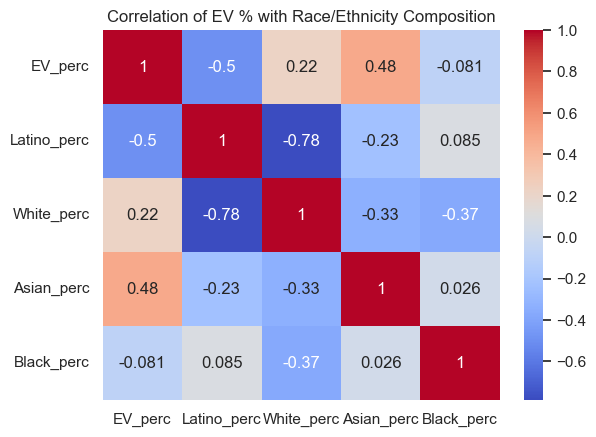

In [13]:
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation of EV % with Race/Ethnicity Composition")
plt.show()

In [14]:
ev_only = vehicles[vehicles["Fuel"].isin(["Electric", "PHEV", "Hybrid", "Electric Hybrid"])]

ev_zip_count = (
    ev_only.groupby("ZIP Code")["Vehicles"]
    .sum()
    .reset_index()
    .rename(columns={"Vehicles": "Registered_EV_Count"})
)

merged = ev_demo.merge(ev_zip_count, how="left", left_on="ZIP", right_on="ZIP Code")
merged["Registered_EV_Count"] = merged["Registered_EV_Count"].fillna(0)

merged.head()

,ZIP,Diesel,Electric,Flex_Fuel,Gasoline,Gasoline_Hybrid,Hydrogen,Natural_Gas,PHEV,Propane,...,Median_Household_Income,Latino_perc,White_perc,Asian_perc,Black_perc,BachOrHigher_perc,Total_Population,Zillow_Home_Value_Index,ZIP Code,Registered_EV_Count
0,94027,89,723,137,4764,380,1,0,167,0,...,250001.0,8.8,68.0,18.5,1.2,84.7,7213,7397088.91,NaN,0.0
1,94022,228,1880,255,12682,1416,8,1,502,0,...,250001.0,5.2,53.7,36.2,0.2,87.6,20069,4383734.10,NaN,0.0
2,94301,141,1229,163,8513,1141,5,5,352,0,...,184932.0,6.2,59.6,24.4,2.5,82.0,17243,3763337.05,NaN,0.0
3,94028,128,645,110,4451,609,1,1,188,0,...,250001.0,9.0,79.5,5.9,0.0,85.2,6582,3708911.26,NaN,0.0
4,94024,253,1981,246,14374,1649,12,3,571,0,...,250001.0,6.3,55.6,31.7,0.9,85.1,24203,3879869.05,NaN,0.0


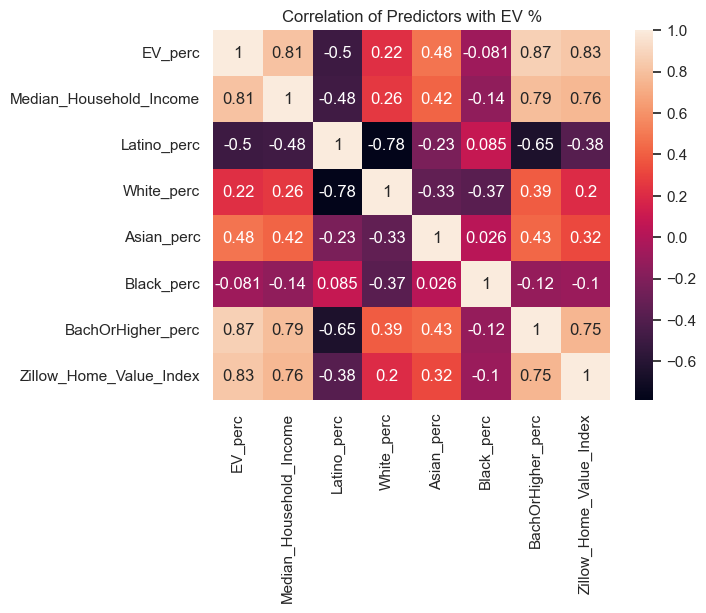

In [18]:
predictors = [
    "Median_Household_Income",
    "Latino_perc",
    "White_perc",
    "Asian_perc",
    "Black_perc",
    "BachOrHigher_perc",
    "Zillow_Home_Value_Index"
]

corr = merged[["EV_perc"] + predictors].corr()
sns.heatmap(corr, annot=True)
plt.title("Correlation of Predictors with EV %")
plt.show()

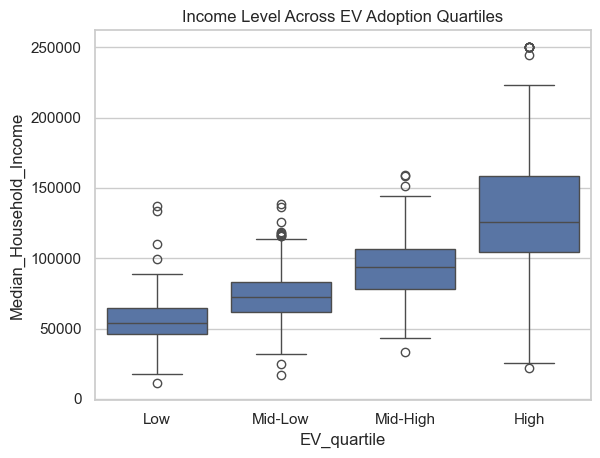

In [20]:
# create EV adoption quartiles to see income level across general categories
merged["EV_quartile"] = pd.qcut(merged["EV_perc"], 4, labels=["Low", "Mid-Low", "Mid-High", "High"])

sns.boxplot(data=merged, x="EV_quartile", y="Median_Household_Income")
plt.title("Income Level Across EV Adoption Quartiles")
plt.show()

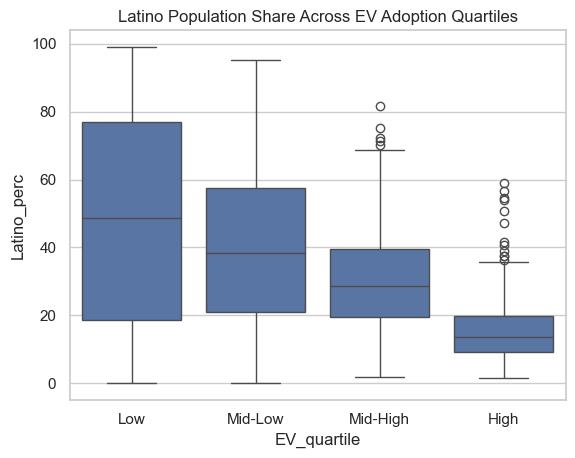

In [21]:
sns.boxplot(data=merged, x="EV_quartile", y="Latino_perc")
plt.title("Latino Population Share Across EV Adoption Quartiles")
plt.show()

In [ ]:
# incorporate alternative fuel station data
stations = pd.read_csv("data/Alternative_Fueling_Stations_-6669030252532885733.csv")
stations["zip"] = (stations["zip"].astype(str).str.extract(r"(\d{5})").iloc[:, 0].fillna("").str.zfill(5))

stations_ca_elec = stations[(stations["state"] == "CA") & (stations["zip"] != "")].copy()

for col in ["ev_level1_evse_num", "ev_level2_evse_num", "ev_dc_fast_num"]:
    stations_ca_elec[col] = pd.to_numeric(stations_ca_elec[col], errors="coerce").fillna(0)

# chargeing stations from levels 1/2 and fast chargers
stations_ca_elec["Total_Charging_Ports"] = (
    stations_ca_elec["ev_level1_evse_num"] +
    stations_ca_elec["ev_level2_evse_num"] +
    stations_ca_elec["ev_dc_fast_num"]
)

agg_data_map = {
    "station_name": "count",
    "Total_Charging_Ports": "sum",
    "ev_level1_evse_num": "sum",
    "ev_level2_evse_num": "sum",
    "ev_dc_fast_num": "sum"
}

charger_zip = stations_ca_elec.groupby("zip").agg(agg_data_map).rename(columns={"station_name": "Charger_Stations"}).reset_index()

ev_mask = (
    vehicles["Fuel"].str.contains("electric", case=False, na=False) |
    vehicles["Fuel"].str.contains("phev", case=False, na=False) |
    vehicles["Fuel"].str.contains("plug-in", case=False, na=False)
)

ev_zip_count = vehicles[ev_mask].groupby("ZIP Code")["Vehicles"].sum().reset_index().rename(columns={"ZIP Code": "ZIP", "Vehicles": "Registered_EV_Count"})

/var/folders/lx/xmxjp545213gbm359rj714p80000gn/T/ipykernel_7603/3773117638.py:2: DtypeWarning: Columns (0,16,33,35,36,39,43,45,48,53,54,55,57,58,61,62,63,64,65,68,69,76,77) have mixed types. Specify dtype option on import or set low_memory=False.
  stations = pd.read_csv("data/Alternative_Fueling_Stations_-6669030252532885733.csv")


In [70]:
merged = ev_demo.merge(ev_zip_count, on="ZIP", how="left")
merged = merged.merge(charger_zip, left_on="ZIP", right_on="zip", how="left")

ev_charge_cols = [
    "Registered_EV_Count",
    "Charger_Stations",
    "Total_Charging_Ports",
    "ev_level1_evse_num",
    "ev_level2_evse_num",
    "ev_dc_fast_num"
]

feature_cols = [
    "Total_EV",
    "Total_Population",
    "EV_perc",
    "Median_Household_Income",
    "Latino_perc",
    "White_perc",
    "Asian_perc",
    "Black_perc",
    "BachOrHigher_perc",
    "Zillow_Home_Value_Index"
]

for col in ev_charge_cols:
    if col in merged.columns:
        merged[col] = pd.to_numeric(merged[col], errors="coerce").fillna(0)

for col in feature_cols:
    if col in merged.columns:
        merged[col] = pd.to_numeric(merged[col], errors="coerce")

In [49]:
# feature engineering for charger access metrics
merged["Chargers_per_1000_EV"] = merged["Total_Charging_Ports"] / (merged["Total_EV"] + 1) * 1000
merged["EVs_per_Charger"] = merged["Total_EV"] / (merged["Total_Charging_Ports"] + 1)
merged["Chargers_per_10k_People"] = merged["Total_Charging_Ports"] / (merged["Total_Population"] + 1) * 10000

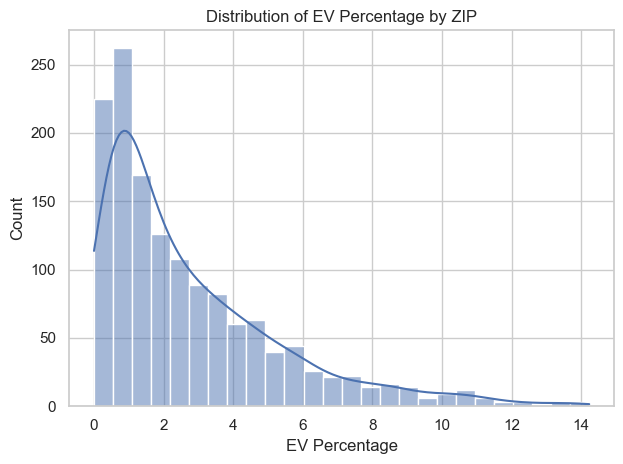

In [29]:
sns.histplot(merged["EV_perc"], kde=True)
plt.title("Distribution of EV Percentage by ZIP")
plt.xlabel("EV Percentage")
plt.tight_layout()
plt.show()

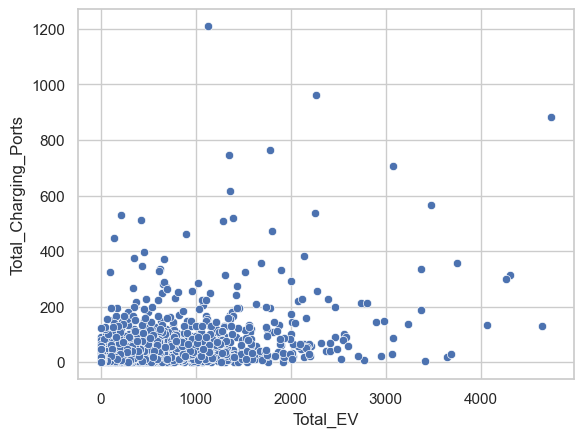

In [33]:
sns.scatterplot(data=merged, x="Total_EV", y="Total_Charging_Ports")
plt.show()

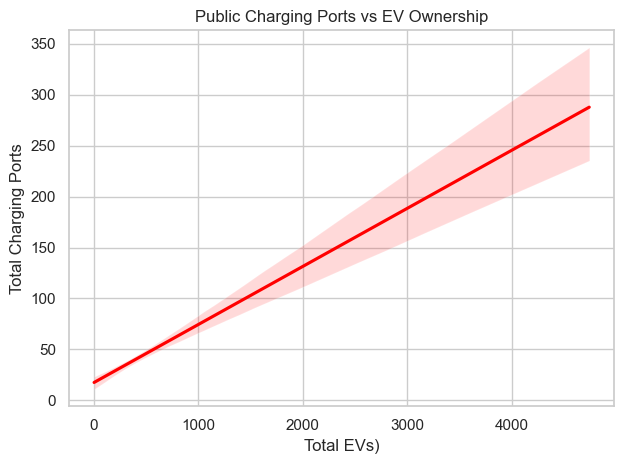

In [35]:
sns.regplot(data=merged, x="Total_EV", y="Total_Charging_Ports", scatter=False, color="red")
plt.title("Public Charging Ports vs EV Ownership")
plt.xlabel("Total EVs)")
plt.ylabel("Total Charging Ports")
plt.tight_layout()
plt.show()

In [44]:
predictors = [
    'Median_Household_Income',
    'Latino_perc',
    'White_perc',
    'Asian_perc',
    'Black_perc',
    'BachOrHigher_perc',
    'Zillow_Home_Value_Index'
]

target_cols = [
    "Chargers_per_1000_EV", 
    "Chargers_per_10k_People", 
    "EVs_per_Charger"
]

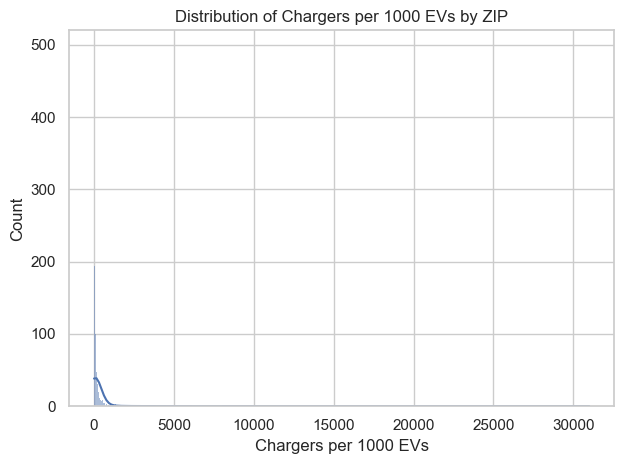

In [51]:
sns.histplot(merged["Chargers_per_1000_EV"], kde=True)
plt.title("Distribution of Chargers per 1000 EVs by ZIP")
plt.xlabel("Chargers per 1000 EVs")
plt.tight_layout()
plt.show()

In [53]:
existing_predictors = [c for c in feature_cols if c in merged.columns]
existing_targets = [c for c in target_cols if c in merged.columns]
corr = merged[existing_predictors + existing_targets].corr()

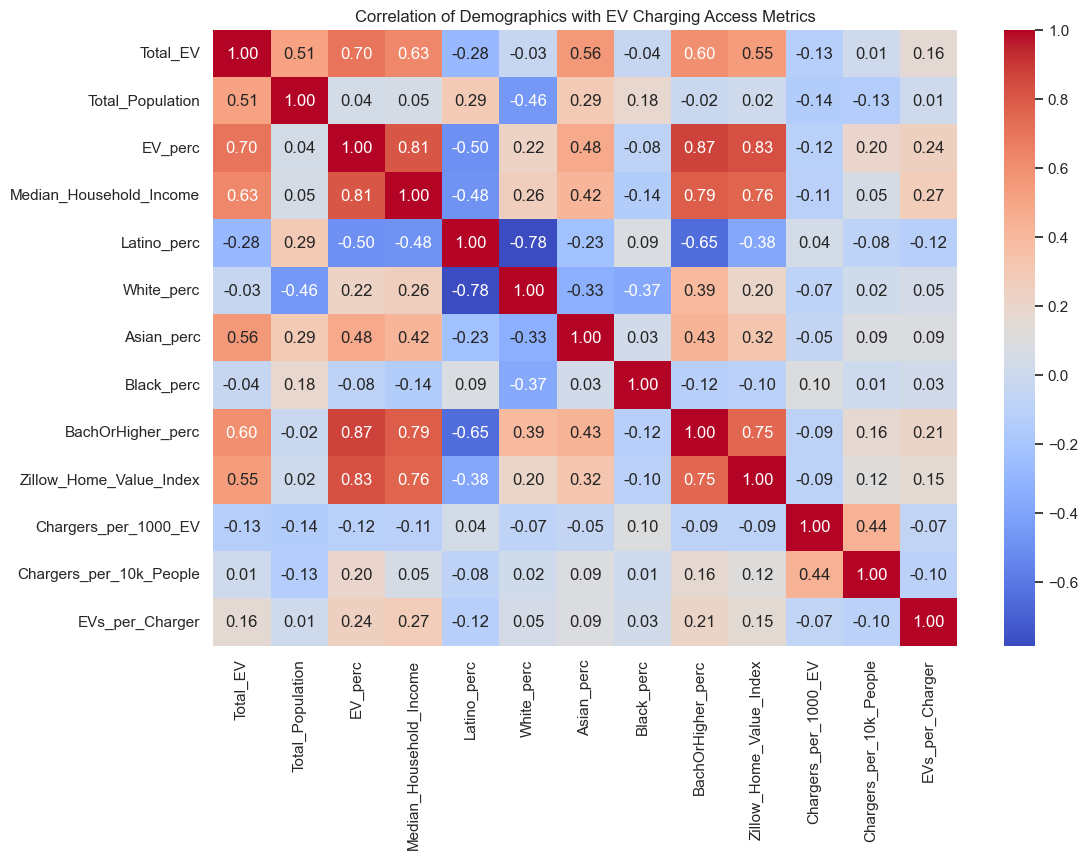

In [67]:
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation of Demographics with EV Charging Access Metrics")
plt.show()

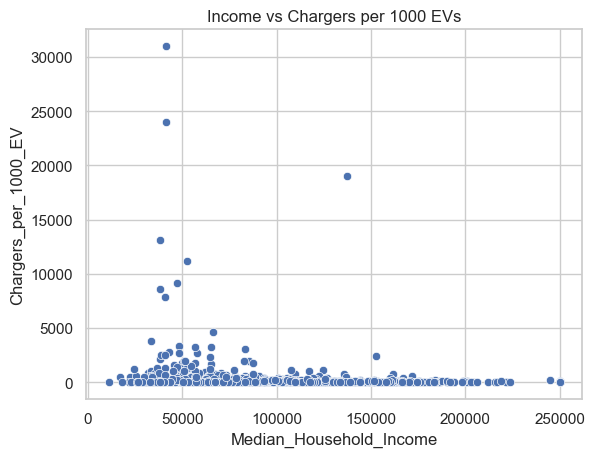

In [66]:
sns.scatterplot(data=merged, x="Median_Household_Income", y="Chargers_per_1000_EV")
plt.title("Income vs Chargers per 1000 EVs")
plt.show()